In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
dataset = 'data'
train = 'data\\Train'
val = 'data\\Val'

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(150,150),
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size=(150,150),
    class_mode='categorical')

Found 775 images belonging to 3 classes.
Found 234 images belonging to 3 classes.


In [12]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [15]:
checkpoint = ModelCheckpoint(
    "model.h5", 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=1)

early = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    mode='auto')

W0718 12:55:20.450480 24236 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [16]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.classes) // BS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.classes) // BS,
    epochs=EPOCHS,
    callbacks=[checkpoint,early])

W0718 12:55:20.584470 24236 deprecation.py:323] From <ipython-input-16-2f54227cf1c0>:7: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0718 12:55:21.565956 24236 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0718 12:55:21.794070 24236 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 24 steps, validate for 7 steps
Epoch 1/20
23/24 [===========================>..] - ETA: 5s - loss: 0.5389 - accuracy: 0.7506 
Epoch 00001: val_accuracy improved from -inf to 0.85565, saving model to model.h5
24/24 [==============================] - 144s 6s/step - loss: 0.5372 - accuracy: 0.7510 - val_loss: 0.5077 - val_accuracy: 0.8557
Epoch 2/20
23/24 [===========================>..] - ETA: 5s - loss: 0.3194 - accuracy: 0.8622 
Epoch 00002: val_accuracy did not improve from 0.85565
24/24 [==============================] - 141s 6s/step - loss: 0.3175 - accuracy: 0.8632 - val_loss: 0.3157 - val_accuracy: 0.8527
Epoch 3/20
23/24 [===========================>..] - ETA: 5s - loss: 0.2133 - accuracy: 0.8978 
Epoch 00003: val_accuracy improved from 0.85565 to 0.88542, saving model to model.h5
24/24 [==============================] - 156s 7s/step - loss: 0.2210 - accuracy: 0.8964 - val_loss: 0.2655 - val_accuracy: 0.8854
Epoch 4/20
23/24 [===========================>..] - ETA: 5s - 

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0

In [18]:
print("Saving turbidity detector model...")
model.save("model.h5")
print("MODEL SAVED")

Saving turbidity detector model...
MODEL SAVED


In [20]:
H.history

{'loss': [0.535128561436408,
  0.320745042002538,
  0.22207712292831647,
  0.18435799311420317,
  0.15586547701949227,
  0.14850058810707698,
  0.14014001415282848,
  0.09964893084435572,
  0.07166007802913199,
  0.0732285149024441,
  0.05948850646875749,
  0.06794403956182712,
  0.05911351909326994,
  0.03706095866297408,
  0.032391877534488835,
  0.039965137205378705,
  0.025485161434944274,
  0.029464612340396032,
  0.05308325891539675,
  0.03539352813580384],
 'accuracy': [0.75100935,
  0.8631673,
  0.8963662,
  0.92462987,
  0.9407805,
  0.93629426,
  0.9425751,
  0.96410954,
  0.9762225,
  0.9726334,
  0.9784657,
  0.97442806,
  0.98295206,
  0.98564374,
  0.98828125,
  0.9869897,
  0.9946163,
  0.9901301,
  0.97891426,
  0.9874131],
 'val_loss': [0.50766407591956,
  0.31572703804288593,
  0.2655262053012848,
  0.2705126575061253,
  0.25887627048151834,
  0.19042333960533142,
  0.21144426507609232,
  0.1805382945707866,
  0.23613299216542924,
  0.3193222539765494,
  0.15813225827

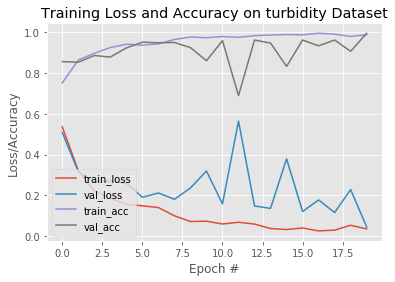

In [24]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on turbidity Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")